In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

plt.style.use("ggplot")

In [0]:
working_path = "dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/"

display(dbutils.fs.ls(working_path))

path,name,size
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/Features.csv,Features.csv,107657595
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/NewFeaturesFinal.csv,NewFeaturesFinal.csv,116243380
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_test_res.csv,X_test_res.csv,20106033
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_train_res-1.csv,X_train_res-1.csv,40679637
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_train_res.csv,X_train_res.csv,59024700
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_20_medium.csv,X_tsf_20_medium.csv,217685299
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_window_20.csv,X_tsf_window_20.csv,35669827
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/df_rolled.csv,df_rolled.csv,134938298
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/individual_files/,individual_files/,0
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/label.csv,label.csv,32196376


In [0]:
# Load vehicle list and nonfailure failure set
vehicles = pd.read_csv('vehicle_list.csv')
dpf_normal = []
dpf_failure = []

for i, e in vehicles.iterrows():
    if(e.dpf_failure == 'No'):
        dpf_normal.append(e.platform_id)
    else:
        dpf_failure.append(e.platform_id)
len(dpf_normal)

69

In [0]:
vehicles.head()

,fleet,truck_number,platform_id,vehicle_year,vehicle_make,vehicle_model,date_of_service,dpf_failure
0,Conway,432 3619,309450,2014,Freightliner,Cascadia,1/4/2019,Yes
1,Conway,432 3577,308374,2014,Freightliner,Cascadia,1/9/2019,Yes
2,Conway,426 6337,10315963,2013,Freightliner,Cascadia,1/17/2019,Yes
3,Conway,532 4279,10314364,2014,Freightliner,Cascadia,1/28/2019,Yes
4,Conway,432 3754,307112,2014,Freightliner,Cascadia,2/13/2019,Yes


In [0]:
window_size = 8

def generate_windows(data, ws=window_size, scaler=StandardScaler):
    ll = len(data)
    label = data.label.tolist()
    data_copy = data.copy(deep=True)
    data_copy = data_copy.drop(['window_end','label'], axis=1)
    dd = scaler().fit_transform(data_copy)
    X = []
    y = []
    label_windowed = []
    
    for i in range(0, (ll - ws)):
        X.append(dd[i:i+ws])
        y.append(dd[i:i+ws])
        label_windowed.append(label[i:i+ws])
    
    return X, y, label_windowed

# this is just to generate a histogram for the 0s, 1s, and 2s.
def generate_single_labels(data, ws=window_size):
    ll = len(data)
    label = data.label.tolist()
    label_windowed = []
    for i in range(0, (ll - ws)):
        label_windowed.append(label[i:i+ws])
    
    return label_windowed

# same
def generate_labels(data, ws=window_size, failure = dpf_failure):
    labels_windowed = []
    for i in failure: # Add each truck to training data
        labels = generate_single_labels(data.loc[i,:])
        labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    return true_labels

def generate_training(data, normal = dpf_normal, ws=window_size):
    Xs = []
    Ys = []
    # Training data does not need label
    for i in normal: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        Xs += X
        Ys += y
    X_tr, X_ts, y_tr, y_ts = [np.array(x) for x in train_test_split(Xs, Ys)]
    return (X_tr, y_tr, X_ts, y_ts)

def generate_all_training(data, normal = dpf_normal, ws=window_size):
    Xs = []
    Ys = []
    # Training data does not need label
    for i in normal: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        Xs += X
        Ys += y
    x1, x2 = [np.array(x) for x in (Xs,Ys)]
    return (x1,x2)

def generate_testing(data, failure = dpf_failure, ws=window_size):
    '''
    return: 
        Xtr, Xts - data from the dpf_failure ones
        y_tr, y_ts - labels from the dpf_failure windows
    '''
    Xs = []
    labels_windowed = [] # testing data needs label
    for i in failure: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        Xs = Xs + X
        labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    X_tr, X_ts, y_tr, y_ts = [np.array(x) for x in train_test_split(X_updated, true_labels_updated)]
    #@@!! hopefully, this will distribute the correct label to the correct window after train_test_split
    
    print('last platform_id: ',i)
    return (X_tr, y_tr, X_ts, y_ts)

#@@ I don't want to test if X_updated is mapped correctly to the true_labels, but problems maybe here

def generate_all_testing(data, failure = dpf_failure, ws=window_size): # no train test split
    '''
    returns a tuple of testing data, X mapped to its label
    '''
    Xs = []
    labels_windowed = []
    for i in failure: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        Xs += X
        labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)
    
def generate_class(a_data, ws = window_size, failure = dpf_failure):
    ll = 0
    dpf_class = []
    
    for i in failure:
        truck_all = a_data.loc[i,:]
        ll = len(truck_all)
        
        
        for j in range(0, (ll-ws)):
#             print(i,j+ws)
#             print(truck_all['Failure'].iloc[j+ws])
            
            if(truck_all['Failure'].iloc[j+ws]==1):
                dpf_class.append(1)
            else:
                dpf_class.append(0)
                
    return dpf_class
def extract_raw(data):
    frames = []
    for i, e in vehicles.iterrows():
        tmp = data[data['platform_id']==e.platform_id]
        try: 
            del tmp['Unnamed: 0']
        except:
            None
        frames.append(tmp)
        
    data_all = pd.concat(frames, axis=0,  keys=vehicles.platform_id.tolist()) # The order of the vehicle.platform_id is the same as tmp's
    return data_all

def extract_trainingdf(data):
    frames = []
    for i, e in vehicles.iterrows():
        tmp = data[data['platform_id']==e.platform_id]
        try: 
            del tmp['platform_id']
            del tmp['Unnamed: 0']
            del tmp['Unnamed: 1']
        except:
            None
        frames.append(tmp)
        
    data_all = pd.concat(frames, axis=0,  keys=vehicles.platform_id.tolist()) # The order of the vehicle.platform_id is the same as tmp's
    return data_all

def label_window(label):
    ''' This function is to generate correct label for each window in the training data. 
    input: 
        label - the set of labels for all data (2D array)
    
    '''
    true_label = []
    for i in range(0,len(label)):
        if label[i].any():
            true_label.append(2)
        else:
            if i!=len(label)-1:
                if label[i+1].any():
                    true_label.append(1)
                else:
                    true_label.append(0)
            else:
                true_label.append(0)
    print("Number of 1s: ",true_label.count(1))
    print("This number should be very close to the number of 1s in tsf_labeled")
    return true_label

def remove_label2(data,label):
    ''' This function is to remove data labeled 2 from a single dataframe

    Returns
    -------
    updated data and label


    '''
    to_remove = []
    for i in range(0,len(data)):
        if label[i]==2:
            to_remove.append(i) #record the positions to remove
    for i in sorted(to_remove, reverse = True):
        del data[i]
        del label[i]
    return data,label

## Import Labeled TSF

In [0]:
# Import Labeled TSF
labeled_tsf = pd.read_csv('data/labeled_tsf.csv')
labeled_tsf.head()

,platform_id,window_end,F1__sum_values,F1__median,F1__mean,F1__length,F1__standard_deviation,F1__variance,F1__root_mean_square,F1__maximum,...,F2__median,F2__mean,F2__length,F2__standard_deviation,F2__variance,F2__root_mean_square,F2__maximum,F2__minimum,vehicle_serviced,label
0,309450,54,43.096559,0.880532,0.845031,51.0,0.100761,0.010153,0.851017,0.97452,...,0.015586,0.024831,51.0,0.017435,0.000304,0.030340,0.055,0.004693,0,0
1,309450,55,42.865651,0.879538,0.840503,51.0,0.104157,0.010849,0.846932,0.97452,...,0.015586,0.025580,51.0,0.017888,0.000320,0.031214,0.055,0.004693,0,0
2,309450,56,43.080893,0.879538,0.844723,51.0,0.100673,0.010135,0.850701,0.97452,...,0.015148,0.024755,51.0,0.017478,0.000305,0.030303,0.055,0.004693,0,0
3,309450,57,43.005762,0.878685,0.843250,51.0,0.099692,0.009939,0.849123,0.97452,...,0.015148,0.024932,51.0,0.017318,0.000300,0.030357,0.055,0.007077,0,0
4,309450,58,42.936007,0.876446,0.841882,51.0,0.099074,0.009816,0.847692,0.97452,...,0.014413,0.024256,51.0,0.017119,0.000293,0.029688,0.055,0.007077,0,0


In [0]:
# List of vehicles in the TSF data:
tsf_list = set(labeled_tsf.platform_id.tolist())

In [0]:
tsf = extract_trainingdf(labeled_tsf)
tsf = tsf.drop('vehicle_serviced',axis=1)
tsf.head()

window_end 
 F1__sum_values 
 F1__median 
 F1__mean 
 F1__length 
 F1__standard_deviation 
 F1__variance 
 F1__root_mean_square 
 F1__maximum 
 F1__minimum 
 F2__sum_values 
 F2__median 
 F2__mean 
 F2__length 
 F2__standard_deviation 
 F2__variance 
 F2__root_mean_square 
 F2__maximum 
 F2__minimum 
 label 
 
 
 
 
 309450 
 0 
 54 
 43.096559 
 0.880532 
 0.845031 
 51.0 
 0.100761 
 0.010153 
 0.851017 
 0.97452 
 0.650454 
 1.266364 
 0.015586 
 0.024831 
 51.0 
 0.017435 
 0.000304 
 0.030340 
 0.055 
 0.004693 
 0 
 
 
 1 
 55 
 42.865651 
 0.879538 
 0.840503 
 51.0 
 0.104157 
 0.010849 
 0.846932 
 0.97452 
 0.650454 
 1.304569 
 0.015586 
 0.025580 
 51.0 
 0.017888 
 0.000320 
 0.031214 
 0.055 
 0.004693 
 0 
 
 
 2 
 56 
 43.080893 
 0.879538 
 0.844723 
 51.0 
 0.100673 
 0.010135 
 0.850701 
 0.97452 
 0.650454 
 1.262512 
 0.015148 
 0.024755 
 51.0 
 0.017478 
 0.000305 
 0.030303 
 0.055 
 0.004693 
 0 
 
 
 3 
 57 
 43.005762 
 0.878685 
 0.843250 
 51.0 
 0.099692 
 0.009939 
 0.849123 
 0.97452 
 0.650454 
 1.271553 
 0.015148 
 0.024932 
 51.0 
 0.017318 
 0.000300 
 0.030357 
 0.055 
 0.007077 
 0 
 
 
 4 
 58 
 42.936007 
 0.876446 
 0.841882 
 51.0 
 0.099074 
 0.009816 
 0.847692 
 0.97452 
 0.650454 
 1.237041 
 0.014413 
 0.024256 
 51.0 
 0.017119 
 0.000293 
 0.029688 
 0.055 
 0.007077 
 0

## Check any missing ID in the data. If so, remove it from the dpf_normal or dpf_failure

In [0]:
for i in dpf_normal:
    if i not in tsf_list:
        dpf_normal.remove(i)
        print('Missing pid for dpf_nonfailure trucks: ',i)
for i in dpf_failure:
    if i not in tsf_list:
        dpf_failure.remove(i)
        print('Missing pid for dpf_nonfailure trucks: ',i)

Missing pid for dpf_nonfailure trucks: 10326079

In [0]:
X, y, XX, yy = generate_training(tsf)
X.shape

(31947, 8, 18)

In [0]:
Xa,ya = generate_all_training(tsf)
Xa.shape

(42597, 8, 18)

# Autoencoders

## Convolutional

In [0]:
model = keras.Sequential(
    [
        layers.Input(shape=(Xa.shape[1], Xa.shape[2])),
        layers.Conv1D(
            filters=10, kernel_size=6, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=5, kernel_size=9, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=5, kernel_size=9, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=10, kernel_size=9, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=9, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
conv1d_18 (Conv1D) (None, 8, 10) 1090 
_________________________________________________________________
dropout_18 (Dropout) (None, 8, 10) 0 
_________________________________________________________________
conv1d_19 (Conv1D) (None, 8, 5) 455 
_________________________________________________________________
conv1d_transpose_27 (Conv1DT (None, 8, 5) 230 
_________________________________________________________________
dropout_19 (Dropout) (None, 8, 5) 0 
_________________________________________________________________
conv1d_transpose_28 (Conv1DT (None, 8, 10) 460 
_________________________________________________________________
conv1d_transpose_29 (Conv1DT (None, 8, 1) 91 
=================================================================
Total params: 2,326
Trainable params: 2,326
Non-trainable params: 0
_________________________________________________________________

In [0]:
train1 = model.fit(
    Xa, #Same as ya
    ya, #Same as Xa
    epochs=100,
    batch_size=100,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/100
341/341 [==============================] - 8s 24ms/step - loss: 0.6905 - val_loss: 0.6492
Epoch 2/100
341/341 [==============================] - 6s 18ms/step - loss: 0.6665 - val_loss: 0.6494
Epoch 3/100
341/341 [==============================] - 8s 24ms/step - loss: 0.6636 - val_loss: 0.6468
Epoch 4/100
341/341 [==============================] - 8s 24ms/step - loss: 0.6624 - val_loss: 0.6472
Epoch 5/100
341/341 [==============================] - 6s 18ms/step - loss: 0.6615 - val_loss: 0.6471
Epoch 6/100
341/341 [==============================] - 5s 14ms/step - loss: 0.6610 - val_loss: 0.6474
Epoch 7/100
341/341 [==============================] - 6s 18ms/step - loss: 0.6605 - val_loss: 0.6465
Epoch 8/100
341/341 [==============================] - 6s 18ms/step - loss: 0.6601 - val_loss: 0.6482
Epoch 9/100
341/341 [==============================] - 5s 16ms/step - loss: 0.6600 - val_loss: 0.6487
Epoch 10/100
341/341 [==============================] - 6s 18ms/step - loss: 0.6597 - val_loss: 0.6475
Epoch 11/100
341/341 [==============================] - 7s 21ms/step - loss: 0.6594 - val_loss: 0.6496
Epoch 12/100
341/341 [==============================] - 6s 16ms/step - loss: 0.6593 - val_loss: 0.6505

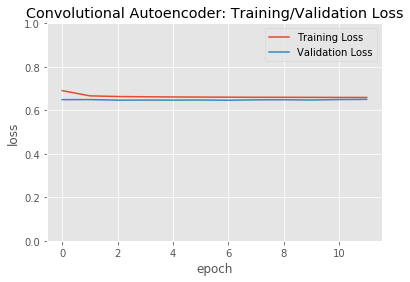

In [0]:
plt.plot(train1.history["loss"], label="Training Loss")
plt.plot(train1.history["val_loss"], label="Validation Loss")
plt.title("Convolutional Autoencoder: Training/Validation Loss")
plt.legend()
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

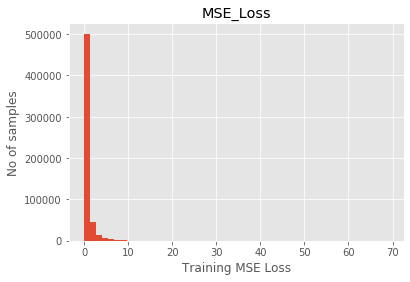

In [0]:
# MSE loss
X_pred = model.predict(X)

train_mse_loss = np.mean(np.power(X_pred - X,2), axis=1)
train_mse_loss = train_mse_loss.reshape((-1))

plt.hist(train_mse_loss, bins=50)
plt.title('MSE_Loss')
plt.xlabel("Training MSE Loss")
plt.ylabel("No of samples")
plt.show()

## LSTM

In [0]:
epochs = 100
batch_size = 100

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

model2 = keras.Sequential()
model2.add(keras.layers.LSTM(10, kernel_initializer='he_uniform', batch_input_shape=(None, Xa.shape[1], Xa.shape[2]), return_sequences=True, name='encoder_1'))
model2.add(keras.layers.LSTM(5, kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
model2.add(keras.layers.RepeatVector(Xa.shape[1], name='encoder_decoder_bridge'))
model2.add(keras.layers.LSTM(5, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model2.add(keras.layers.LSTM(10, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model2.add(keras.layers.TimeDistributed(keras.layers.Dense(Xa.shape[2])))
model2.compile(loss="mse",optimizer='adam')
model2.build()
model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
encoder_1 (LSTM) (None, 8, 10) 1160 
_________________________________________________________________
encoder_2 (LSTM) (None, 5) 320 
_________________________________________________________________
encoder_decoder_bridge (Repe (None, 8, 5) 0 
_________________________________________________________________
decoder_2 (LSTM) (None, 8, 5) 220 
_________________________________________________________________
decoder_3 (LSTM) (None, 8, 10) 640 
_________________________________________________________________
time_distributed_5 (TimeDist (None, 8, 18) 198 
=================================================================
Total params: 2,538
Trainable params: 2,538
Non-trainable params: 0
_________________________________________________________________

In [0]:
train2 = model2.fit(x=X, y=y, validation_data=(XX, yy),epochs=100, batch_size=batch_size, shuffle=True, 
                    callbacks=[early_stop])


Epoch 1/100
320/320 [==============================] - 20s 64ms/step - loss: 0.6122 - val_loss: 0.4429
Epoch 2/100
320/320 [==============================] - 17s 53ms/step - loss: 0.3667 - val_loss: 0.3127
Epoch 3/100
320/320 [==============================] - 17s 53ms/step - loss: 0.2809 - val_loss: 0.2556
Epoch 4/100
320/320 [==============================] - 14s 45ms/step - loss: 0.2388 - val_loss: 0.2206
Epoch 5/100
320/320 [==============================] - 21s 66ms/step - loss: 0.2031 - val_loss: 0.1881
Epoch 6/100
320/320 [==============================] - 17s 54ms/step - loss: 0.1800 - val_loss: 0.1717
Epoch 7/100
320/320 [==============================] - 17s 53ms/step - loss: 0.1683 - val_loss: 0.1637
Epoch 8/100
320/320 [==============================] - 16s 50ms/step - loss: 0.1623 - val_loss: 0.1590
Epoch 9/100
320/320 [==============================] - 16s 49ms/step - loss: 0.1583 - val_loss: 0.1556
Epoch 10/100
320/320 [==============================] - 16s 50ms/step - loss: 0.1552 - val_loss: 0.1530
Epoch 11/100
320/320 [==============================] - 15s 48ms/step - loss: 0.1528 - val_loss: 0.1507
Epoch 12/100
320/320 [==============================] - 20s 63ms/step - loss: 0.1505 - val_loss: 0.1478
Epoch 13/100
320/320 [==============================] - 17s 52ms/step - loss: 0.1408 - val_loss: 0.1302
Epoch 14/100
320/320 [==============================] - 16s 51ms/step - loss: 0.1275 - val_loss: 0.1246
Epoch 15/100
320/320 [==============================] - 18s 57ms/step - loss: 0.1235 - val_loss: 0.1216
Epoch 16/100
320/320 [==============================] - 14s 45ms/step - loss: 0.1211 - val_loss: 0.1198
Epoch 17/100
320/320 [==============================] - 16s 49ms/step - loss: 0.1194 - val_loss: 0.1187
Epoch 18/100
320/320 [==============================] - 15s 47ms/step - loss: 0.1181 - val_loss: 0.1173
Epoch 19/100
320/320 [==============================] - 13s 40ms/step - loss: 0.1170 - val_loss: 0.1167
Epoch 20/100
320/320 [==============================] - 12s 38ms/step - loss: 0.1161 - val_loss: 0.1157
Epoch 21/100
320/320 [==============================] - 13s 39ms/step - loss: 0.1154 - val_loss: 0.1151

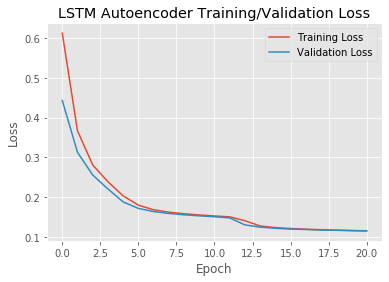

In [0]:
plt.plot(train2.history["loss"], label="Training Loss")
plt.plot(train2.history["val_loss"], label="Validation Loss")
plt.title("LSTM Autoencoder Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

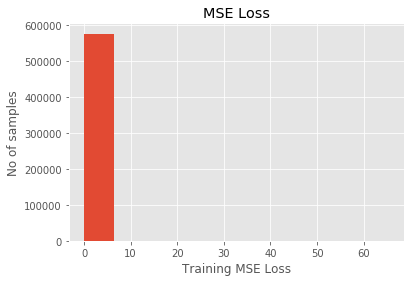

In [0]:
# MSE loss
X_pred = model2.predict(X)
train_mse_loss = np.mean(np.power(X_pred - X,2), axis=1)
train_mse_loss = train_mse_loss.reshape((-1))

plt.hist(train_mse_loss, bins=10)
plt.title("MSE Loss")
plt.xlabel("Training MSE Loss")
plt.ylabel("No of samples")
plt.show()



# Test on dpf_failure set

In [0]:
A, l = generate_all_testing(tsf)

Number of 1s: 84
This number should be very close to the number of 1s in tsf_labeled

In [0]:
labels_with_2 = generate_labels(tsf)

Number of 1s: 84
This number should be very close to the number of 1s in tsf_labeled

(array([53343., 0., 0., 0., 0., 84., 0., 0.,
 0., 672.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

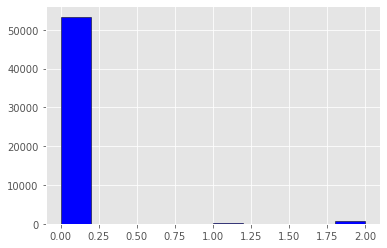

In [0]:
plt.hist(labels_with_2, color='blue',edgecolor='black')

(array([53343., 0., 0., 0., 0., 0., 0., 0.,
 0., 84.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

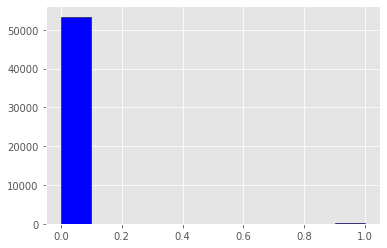

In [0]:
# There should be no 2s in the histogram. 
plt.hist(l, color = 'blue', edgecolor = 'black')

In [0]:
def mse_sum(mse):
    mse_sum=[]
    for i in range(0,mse.shape[0]):
        mse_sum.append(np.sum(mse[i]))
    len(mse_sum)
    return mse_sum

## Test convolutional

## Test LSTM - threshold according to train predict: 15

In [0]:
A_pred = model2.predict(A)
mse = np.mean(np.power(A - A_pred, 2), axis=1)
ms = mse_sum(mse)

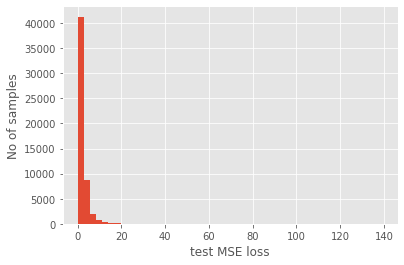

In [0]:
plt.hist(ms, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

In [0]:
error_df_test = pd.DataFrame({'Reconstruction_error': ms,
                        'True_class': l})
error_df_test = error_df_test.reset_index()

/Users/emma/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version. Convert to a numpy array before indexing instead.
 x[:, None]
/Users/emma/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version. Convert to a numpy array before indexing instead.
 x = x[:, np.newaxis]
/Users/emma/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version. Convert to a numpy array before indexing instead.
 y = y[:, np.newaxis]

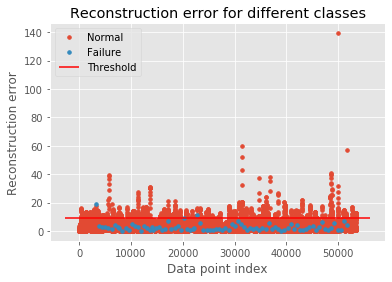

In [0]:
threshold_fixed = 9
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

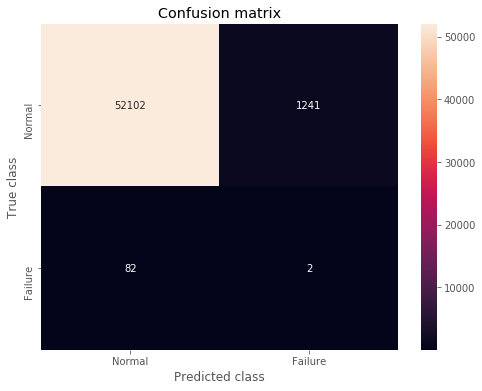

In [0]:
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
print('\nClassification Report:')
print(classification_report(error_df_test.True_class, y_pred))
print('\nF1 Score:')
print(f1_score(error_df_test.True_class, y_pred, average = None))

Classification Report:

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-84314> in <module> 
 1 print ( '\nClassification Report:' ) 
 ----> 2 print ( classification_report ( error_df_test . True_class , y_pred ) ) 
 3 print ( '\nF1 Score:' ) 
 4 print ( f1_score ( error_df_test . True_class , y_pred , average = None ) ) 

 NameError : name 'error_df_test' is not defined

In [0]:
# Note for tomorrow's work:
## Get the tsf_20 with the label column
## MLopt
## Feature selection with TS Fresh


## Training with tsf_20

In [0]:
# Import Labeled TSF
labeled_20 = pd.read_csv('data/tsf_20.csv')
# List of vehicles in the TSF data:
tsf_list20 = set(labeled_20.platform_id.tolist())

In [0]:
labeled_20.head()

,platform_id,window_end,F1__sum_values,F1__median,F1__mean,F1__length,F1__standard_deviation,F1__variance,F1__root_mean_square,F1__maximum,F1__minimum,F2__sum_values,F2__median,F2__mean,F2__length,F2__standard_deviation,F2__variance,F2__root_mean_square,F2__maximum,F2__minimum
0,301972,168,13.797204,0.650454,0.65701,21.0,0.029319,0.00086,0.657664,0.788129,0.650454,1.316344,0.055,0.062683,21.0,0.034361,0.001181,0.071483,0.216352,0.055
1,301972,169,13.797204,0.650454,0.65701,21.0,0.029319,0.00086,0.657664,0.788129,0.650454,1.316344,0.055,0.062683,21.0,0.034361,0.001181,0.071483,0.216352,0.055
2,301972,170,13.797204,0.650454,0.65701,21.0,0.029319,0.00086,0.657664,0.788129,0.650454,1.316344,0.055,0.062683,21.0,0.034361,0.001181,0.071483,0.216352,0.055
3,301972,171,13.797204,0.650454,0.65701,21.0,0.029319,0.00086,0.657664,0.788129,0.650454,1.316344,0.055,0.062683,21.0,0.034361,0.001181,0.071483,0.216352,0.055
4,301972,172,13.797204,0.650454,0.65701,21.0,0.029319,0.00086,0.657664,0.788129,0.650454,1.316344,0.055,0.062683,21.0,0.034361,0.001181,0.071483,0.216352,0.055


In [0]:
set(tsf_list20) - set(tsf_list)

{10326079}

In [0]:
dpf_normal = []
dpf_failure = []

for i, e in vehicles.iterrows():
    if(e.dpf_failure == 'No'):
        dpf_normal.append(e.platform_id)
    else:
        dpf_failure.append(e.platform_id)

In [0]:
for i in dpf_normal:
    if i not in tsf_list20:
        dpf_normal.remove(i)
        print('Missing pid for dpf_nonfailure trucks: ',i)
for i in dpf_failure:
    if i not in tsf_list20:
        dpf_failure.remove(i)
        print('Missing pid for dpf_nonfailure trucks: ',i)

In [0]:
tsf_20 = extract_trainingdf(labeled_20)
tsf_20.head()

window_end 
 F1__sum_values 
 F1__median 
 F1__mean 
 F1__length 
 F1__standard_deviation 
 F1__variance 
 F1__root_mean_square 
 F1__maximum 
 F1__minimum 
 F2__sum_values 
 F2__median 
 F2__mean 
 F2__length 
 F2__standard_deviation 
 F2__variance 
 F2__root_mean_square 
 F2__maximum 
 F2__minimum 
 
 
 
 
 309450 
 23492 
 21 
 18.276293 
 0.901339 
 0.870300 
 21.0 
 0.094365 
 0.008905 
 0.875401 
 0.967459 
 0.650454 
 0.561350 
 0.019099 
 0.026731 
 21.0 
 0.016428 
 0.000270 
 0.031375 
 0.055 
 0.004693 
 
 
 23493 
 22 
 18.237851 
 0.901339 
 0.868469 
 21.0 
 0.093286 
 0.008702 
 0.873465 
 0.967459 
 0.650454 
 0.563100 
 0.019099 
 0.026814 
 21.0 
 0.016334 
 0.000267 
 0.031398 
 0.055 
 0.004693 
 
 
 23494 
 23 
 18.244855 
 0.901339 
 0.868803 
 21.0 
 0.093379 
 0.008720 
 0.873806 
 0.967459 
 0.650454 
 0.558745 
 0.019099 
 0.026607 
 21.0 
 0.016503 
 0.000272 
 0.031309 
 0.055 
 0.004693 
 
 
 23495 
 24 
 18.272488 
 0.901339 
 0.870118 
 21.0 
 0.094032 
 0.008842 
 0.875185 
 0.967459 
 0.650454 
 0.563095 
 0.022716 
 0.026814 
 21.0 
 0.016425 
 0.000270 
 0.031445 
 0.055 
 0.004693 
 
 
 23496 
 25 
 18.237972 
 0.901339 
 0.868475 
 21.0 
 0.094123 
 0.008859 
 0.873560 
 0.967459 
 0.650454 
 0.553377 
 0.022716 
 0.026351 
 21.0 
 0.016833 
 0.000283 
 0.031269 
 0.055 
 0.004693

In [0]:
try: 
    tsf_20 = tsf_20.drop('vehicle_serviced',axis=1)
except:
    None
tsf_20.head()

window_end 
 F1__sum_values 
 F1__median 
 F1__mean 
 F1__length 
 F1__standard_deviation 
 F1__variance 
 F1__root_mean_square 
 F1__maximum 
 F1__minimum 
 F2__sum_values 
 F2__median 
 F2__mean 
 F2__length 
 F2__standard_deviation 
 F2__variance 
 F2__root_mean_square 
 F2__maximum 
 F2__minimum 
 
 
 
 
 309450 
 23492 
 21 
 18.276293 
 0.901339 
 0.870300 
 21.0 
 0.094365 
 0.008905 
 0.875401 
 0.967459 
 0.650454 
 0.561350 
 0.019099 
 0.026731 
 21.0 
 0.016428 
 0.000270 
 0.031375 
 0.055 
 0.004693 
 
 
 23493 
 22 
 18.237851 
 0.901339 
 0.868469 
 21.0 
 0.093286 
 0.008702 
 0.873465 
 0.967459 
 0.650454 
 0.563100 
 0.019099 
 0.026814 
 21.0 
 0.016334 
 0.000267 
 0.031398 
 0.055 
 0.004693 
 
 
 23494 
 23 
 18.244855 
 0.901339 
 0.868803 
 21.0 
 0.093379 
 0.008720 
 0.873806 
 0.967459 
 0.650454 
 0.558745 
 0.019099 
 0.026607 
 21.0 
 0.016503 
 0.000272 
 0.031309 
 0.055 
 0.004693 
 
 
 23495 
 24 
 18.272488 
 0.901339 
 0.870118 
 21.0 
 0.094032 
 0.008842 
 0.875185 
 0.967459 
 0.650454 
 0.563095 
 0.022716 
 0.026814 
 21.0 
 0.016425 
 0.000270 
 0.031445 
 0.055 
 0.004693 
 
 
 23496 
 25 
 18.237972 
 0.901339 
 0.868475 
 21.0 
 0.094123 
 0.008859 
 0.873560 
 0.967459 
 0.650454 
 0.553377 
 0.022716 
 0.026351 
 21.0 
 0.016833 
 0.000283 
 0.031269 
 0.055 
 0.004693

In [0]:
X2, y2, XX2, yy2 = generate_training(tsf_20,dpf_normal,20)
X2.shape

---------------------------------------------------------------------------
AttributeError Traceback (most recent call last)
 in 
----> 1 X2, y2, XX2, yy2 = generate_training(tsf_20,dpf_normal,20)
 2 X2.shape

 in generate_training(data, normal, ws)
 43 # Training data does not need label
 44 for i in normal: # Add each truck to training data
---> 45 X, y, labels = generate_windows(data.loc[i,:],ws)
 46 Xs += X
 47 Ys += y

 in generate_windows(data, ws, scaler)
 3 def generate_windows(data, ws=window_size, scaler=StandardScaler):
 4 ll = len(data)
----> 5 label = data.label.tolist()
 6 data_copy = data.copy(deep=True)
 7 data_copy = data_copy.drop(['window_end','label'], axis=1)

~/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py in __getattr__(self, name)
 5463 if self._info_axis._can_hold_identifiers_and_holds_name(name):
 5464 return self[name]
-> 5465 return object.__getattribute__(self, name)
 5466 
 5467 def __setattr__(self, name: str, value) -> None:

AttributeError: 'DataFrame' object has no attribute 'label'

In [0]:
train20 = model2.fit(x=X2, y=y2, validation_data=(XX2, yy2),epochs=100, batch_size=batch_size, shuffle=True, 
                    callbacks=[early_stop])



## Testing with tsf_20

In [0]:
AA, ll = generate_all_testing(tsf)

In [0]:
A20_pred = model2.predict(AA)
mse = np.mean(np.power(AA - AA_pred, 2), axis=1)
ms = mse_sum(mse)

In [0]:
plt.hist(ms, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

In [0]:
error_df_test_20 = pd.DataFrame({'Reconstruction_error': ms,
                        'True_class': ll})
error_df_test_20 = error_df_test_20.reset_index()

In [0]:
threshold_fixed = 9
groups = error_df_test_20.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [0]:
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test_20.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test_20.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()